In [26]:
import random
import numpy as np
import matplotlib.pyplot as plt
import imageio

from libs.util import readImg, psnr
from libs.CFA import rgb2cfa, demosaicked

In [27]:
def permuted_2(perm, height, width, seed):
    _perm = perm.ravel()
    np.random.seed(seed)
    permuted = np.random.permutation(_perm)
    return permuted.reshape(height, width)

def generate_ac(H, W, seed, t):
    random.seed(seed)
    ac = np.zeros((H, W), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            ac[i][j] = random.randint(0, 2**t-1)
    return ac

def authentication_code(image, t):
    return image.sum(axis=2) % 2**t

In [37]:
### show the image undetect area
def ImageUnDetectArea(image, detected):
    _image = np.copy(image)
    _image[:, :, 0]*=detected
    _image[:, :, 1]*=detected
    _image[:, :, 2]*=detected
    return _image

def pltArea(ax, min_position, max_position):
    TA_front = [
        (min_position[0], min_position[1]),
        (max_position[0], min_position[1]),
        (max_position[0], max_position[1]),
        (min_position[0], max_position[1]),
        (min_position[0], min_position[1])
    ]
    ax.plot([p[1] for p in TA_front], [p[0] for p in TA_front], "-r")
    return ax

## Detect Embedded Image Demo

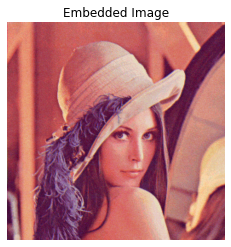

In [108]:
image = imageio.imread("./img/lena_ACembedded_t=4.png")
plt.imshow(image)
plt.title("Embedded Image")
plt.axis('off')
plt.show()
H, W = image.shape[:2]
Sd = 7
t = 4
PK = 7

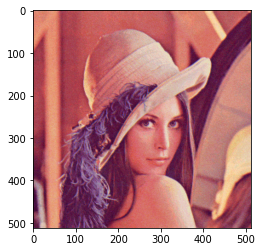

In [81]:
acs = generate_ac(H, W, Sd, t)
permuted_acs = permuted_2(acs, H, W, PK)
pvs = authentication_code(image, t)
## 如果顯示黑色區塊，該區快就被竄改過
## When the area is black, the area has the tamper probably
tampered = (permuted_acs == pvs)
untampered_image = ImageUnDetectArea(image, tampered)
plt.imshow(untampered_image)

## Detect Embedded and Tampered Image Demo

In [109]:
tampered_image = imageio.imread("./img/lena_ACembedded_t=4_tampered3.png")
tampered_image = tampered_image[:, :, 0:3]

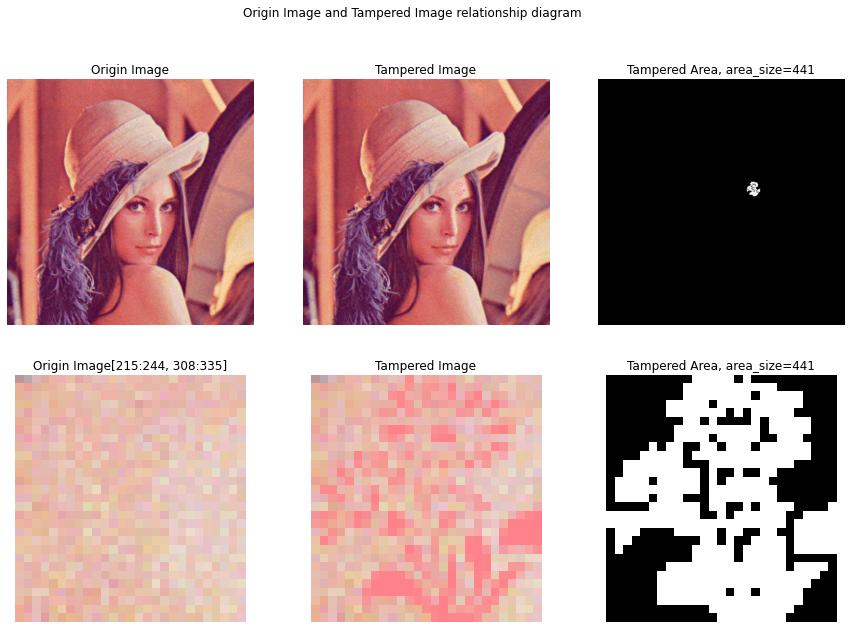

In [103]:
tampered = np.equal(image, tampered_image)
tampered_area = ~(tampered[:, :, 0]*tampered[:, :, 1]*tampered[:, :, 2])
tampered_size = tampered_area.sum()

tampered_arg = np.argwhere(tampered_area == True)
TA_min = [tampered_arg[:, 0].min(), tampered_arg[:, 1].min()]
TA_max = [tampered_arg[:, 0].max(), tampered_arg[:, 1].max()]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Origin Image and Tampered Image relationship diagram")
axs[0, 0].imshow(image)
axs[0, 0].set_title("Origin Image")
axs[0, 0].axis('off')
axs[0, 1].imshow(tampered_image)
axs[0, 1].set_title("Tampered Image")
axs[0, 1].axis('off')
axs[0, 2].imshow(tampered_area, cmap="gray")
axs[0, 2].set_title("Tampered Area, area_size={}".format(tampered_size))
axs[0, 2].axis('off')
axs[1, 0].imshow(image[TA_min[0]:TA_max[0], TA_min[1]:TA_max[1]])
axs[1, 0].set_title("Origin Image[{}:{}, {}:{}]".format(TA_min[0], TA_max[0], TA_min[1], TA_max[1]))
axs[1, 0].axis('off')
axs[1, 1].imshow(tampered_image[TA_min[0]:TA_max[0], TA_min[1]:TA_max[1]])
axs[1, 1].set_title("Tampered Image")
axs[1, 1].axis('off')
axs[1, 2].imshow(tampered_area[TA_min[0]:TA_max[0], TA_min[1]:TA_max[1]], cmap="gray")
axs[1, 2].set_title("Tampered Area, area_size={}".format(tampered_size))
axs[1, 2].axis('off')
plt.show()

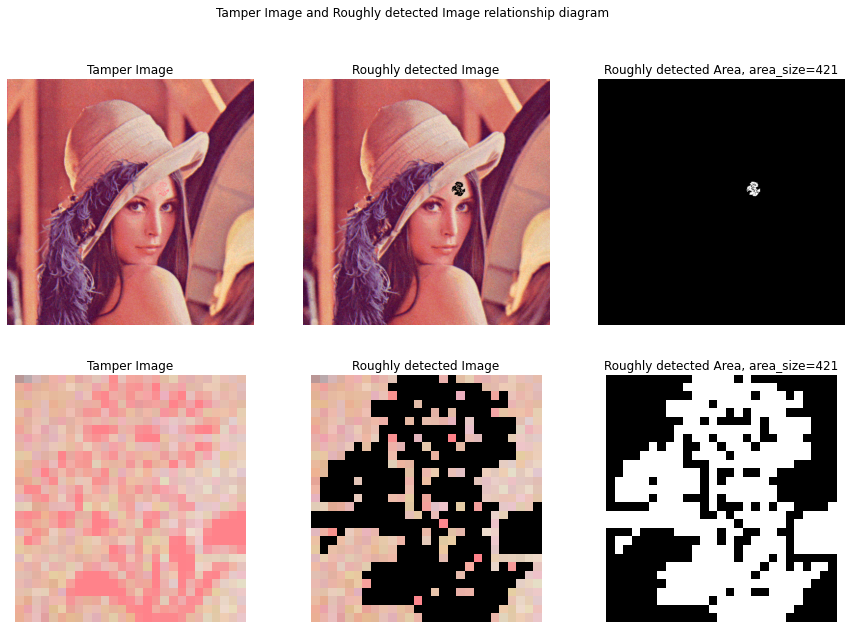

In [104]:
pvs = authentication_code(tampered_image, t)
## detected_area.shape = (H, W)
detected_area = (permuted_acs == pvs)
detected_size = (~detected_area).sum()
detected_arg = np.argwhere(~detected_area == True)

detected_image = ImageUnDetectArea(tampered_image, detected_area)

## tamper area
DA_min = [detected_arg[:, 0].min(), detected_arg[:, 1].min()]
DA_max = [detected_arg[:, 0].max(), detected_arg[:, 1].max()]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Tamper Image and Roughly detected Image relationship diagram")
axs[0, 0].set_title("Tamper Image")
axs[0, 0].imshow(tampered_image)
axs[0, 0].axis('off')
axs[0, 1].set_title("Roughly detected Image")
axs[0, 1].imshow(detected_image)
axs[0, 1].axis('off')
axs[0, 2].set_title("Roughly detected Area, area_size={}".format(detected_size))
axs[0, 2].imshow(~detected_area, cmap="gray")
axs[0, 2].axis('off')
axs[1, 0].set_title("Tamper Image")
axs[1, 0].imshow(tampered_image[DA_min[0]:DA_max[0], DA_min[1]:DA_max[1]])
axs[1, 0].axis('off')
axs[1, 1].set_title("Roughly detected Image")
axs[1, 1].imshow(detected_image[DA_min[0]:DA_max[0], DA_min[1]:DA_max[1]])
axs[1, 1].axis('off')
axs[1, 2].set_title("Roughly detected Area, area_size={}".format(detected_size))
axs[1, 2].imshow(~detected_area[DA_min[0]:DA_max[0], DA_min[1]:DA_max[1]], cmap="gray")
axs[1, 2].axis('off')
plt.show()

## Finally Detect process

Before


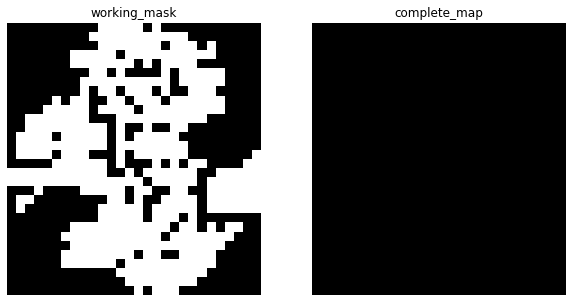

In [95]:
## detected pixel arg
detected_arg = np.argwhere(~detected_area == True)
## detected area block
## [
##  [min_y, min_x],
##  [max_y, max_y]
## ]
patch = [
    [detected_arg[:, 0].min(), detected_arg[:, 1].min()],
    [detected_arg[:, 0].max(), detected_arg[:, 1].max()]
]
patch_height, patch_width = patch[1][0] - patch[0][0]+1, patch[1][1] - patch[0][1]+1

## detect range
working_mask = ~detected_area[patch[0][0]:patch[1][0]+1, patch[0][1]:patch[1][1]+1]
## 檢測紀錄
complete_map = np.zeros(shape=(patch_height, patch_width), dtype=np.bool)

print("Before")
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(working_mask, cmap="gray")
axs[0].set_title("working_mask")
axs[0].axis('off')
axs[1].imshow(complete_map, cmap="gray")
axs[1].set_title("complete_map")
axs[1].axis('off')
plt.show()

In [96]:
def refinement(y, x):
    ## 是否已檢測過
    complete_map[y, x] = True
    cases = np.array([
        [
            [1, 0, 0],
            [0, 0, 0],
            [0, 0, 1]
        ],
        [
            [0, 1, 0],
            [0, 0, 0],
            [0, 1, 0]
        ],
        [
            [0, 0, 1],
            [0, 0, 0],
            [1, 0, 0]
        ],
        [
            [0, 0, 0],
            [1, 0, 1],
            [0, 0, 0]
        ]
    ])
    cases_range = np.array([
        [
            [-2, 0],
            [-2, 0],
        ],
        [
            [-2, 0],
            [-1, 1]
        ],
        [
            [-2, 0],
            [0, 2]
        ],
        [
            [-1, 1],
            [0, 2]
        ],
        [
            [0, 2],
            [0, 2]
        ],
        [
            [0, 2],
            [-1, 1]
        ],
        [
            [0, 2],
            [-2, 0]
        ],
        [
            [-1, 1],
            [-2, 0]
        ]
    ])
    
    for i in range(8):
        case_patch = [
            [y+cases_range[i, 0, 0], y+cases_range[i, 0, 1]],
            [x+cases_range[i, 1, 0], x+cases_range[i, 1, 1]]
        ]
        if case_patch[0][0]<0 or case_patch[0][1]>=patch_height or case_patch[1][0]<0 or case_patch[1][1]>=patch_width:
            continue
        block = working_mask[case_patch[0][0]:case_patch[0][1]+1, case_patch[1][0]:case_patch[1][1]+1]*cases[i%4]
        if np.array_equal(block, cases[i%4]):
            ap_point = [y+cases_range[i, 0].sum()//2, x+cases_range[i, 1].sum()//2]
            if ap_point[0]>=0 and ap_point[0]<=patch_height and ap_point[1]>=0 and ap_point[1]<=patch_width:
                working_mask[ap_point[0], ap_point[1]] = True
                if complete_map[ap_point[0], ap_point[1]] == False:
                    refinement(ap_point[0], ap_point[1])
    return True

After


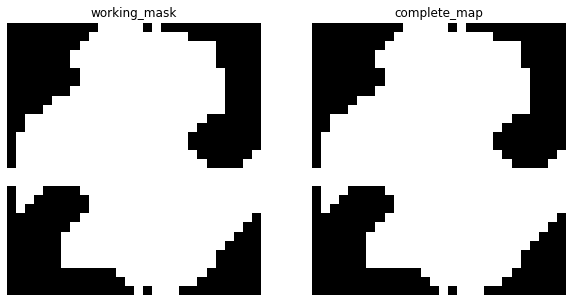

In [97]:
for p in detected_arg:
    try:
        y, x = p[0]-patch[0][0], p[1]-patch[0][1]
        refinement(y, x)
        if np.array_equal(working_mask, complete_map):
            break
    except RecursionError as e:
        print("[RecursionError]", e, "Try Again!!")
print("After")
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(working_mask, cmap="gray")
axs[0].set_title("working_mask")
axs[0].axis('off')
axs[1].imshow(complete_map, cmap="gray")
axs[1].set_title("complete_map")
axs[1].axis('off')
plt.show()

## Update Detected Result

In [105]:
finally_detected_area = detected_area
finally_detected_area[patch[0][0]:patch[1][0]+1, patch[0][1]:patch[1][1]+1] = ~working_mask
finally_detected_size = (working_mask).sum()
finally_detected_image = ImageUnDetectArea(tampered_image, finally_detected_area)

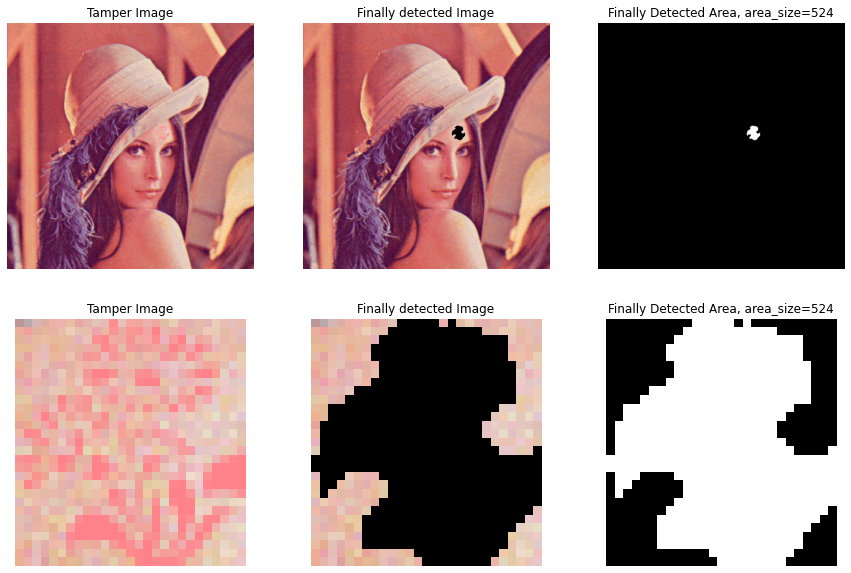

In [106]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].set_title("Tamper Image")
axs[0, 0].imshow(tampered_image)
axs[0, 0].axis('off')
axs[0, 1].set_title("Finally detected Image")
axs[0, 1].imshow(finally_detected_image)
axs[0, 1].axis('off')
axs[0, 2].set_title("Finally Detected Area, area_size={}".format(finally_detected_size))
axs[0, 2].imshow(~finally_detected_area, cmap="gray")
axs[0, 2].axis('off')
axs[1, 0].set_title("Tamper Image")
axs[1, 0].imshow(tampered_image[TA_min[0]:TA_max[0], TA_min[1]:TA_max[1]])
axs[1, 0].axis('off')
axs[1, 1].set_title("Finally detected Image")
axs[1, 1].imshow(finally_detected_image[TA_min[0]:TA_max[0], TA_min[1]:TA_max[1]])
axs[1, 1].axis('off')
axs[1, 2].set_title("Finally Detected Area, area_size={}".format(finally_detected_size))
axs[1, 2].imshow(~finally_detected_area[TA_min[0]:TA_max[0], TA_min[1]:TA_max[1]], cmap="gray")
axs[1, 2].axis('off')
plt.show()

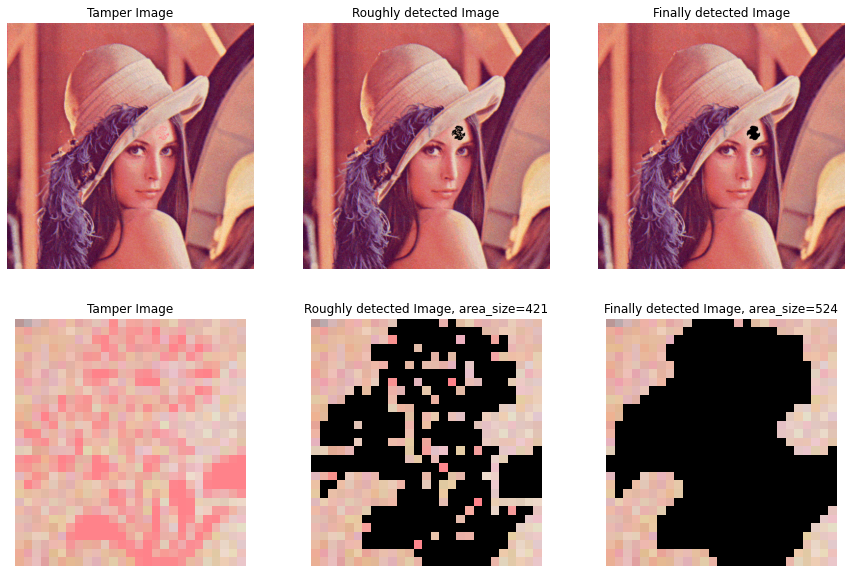

In [107]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].set_title("Tamper Image")
axs[0, 0].imshow(tampered_image)
axs[0, 0].axis('off')
axs[0, 1].set_title("Roughly detected Image")
axs[0, 1].imshow(detected_image)
axs[0, 1].axis('off')
axs[0, 2].set_title("Finally detected Image")
axs[0, 2].imshow(finally_detected_image)
axs[0, 2].axis('off')
axs[1, 0].set_title("Tamper Image")
axs[1, 0].imshow(tampered_image[TA_min[0]:TA_max[0], TA_min[1]:TA_max[1]])
axs[1, 0].axis('off')
axs[1, 1].set_title("Roughly detected Image, area_size={}".format(detected_size))
axs[1, 1].imshow(detected_image[TA_min[0]:TA_max[0], TA_min[1]:TA_max[1]])
axs[1, 1].axis('off')
axs[1, 2].set_title("Finally detected Image, area_size={}".format(finally_detected_size))
axs[1, 2].imshow(finally_detected_image[TA_min[0]:TA_max[0], TA_min[1]:TA_max[1]])
axs[1, 2].axis('off')
plt.show()